In [1]:
############################################################################
# HER2 Overexpression,This is the analysis of the results of ensemble clustering
# With a CTNND1-centric view of cluster analysis
############################################################################
%matplotlib inline 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#from cooccurrence import coMat
import openensembles as oe
import finishing as finish
import networkx as nx

import pickle


[dataObj_P, dataObj_24H, c_P, c_24H, c_link_P, c_link_24H, c_g_P, c_g_24H] = pickle.load( open( "P_24H_ensembleClusterworkspace.p", "rb" ))
coMat_P = c_P.co_occurrence_matrix('parent')
coMat_24H = c_24H.co_occurrence_matrix('parent')

graph_threshold = 0.7

## Plot the SHC and CTNND1 dynamics

In [2]:
def returnSelectedDataByGeneSite(df, gene_sites, data_cols):
    selectData = pd.DataFrame(columns=data_cols)
    for site in gene_sites:
        series = df[df['gene_site']==site][data_cols]
        selectData = selectData.append(series)
    return selectData

In [3]:
dfSub = pd.DataFrame()

index = dataObj_P.df.index.get_loc('CTNND1_Y228')
dfSub['P CTNND1_Y228'] = dataObj_P.D['parent'][index,:]

index = dataObj_P.df.index.get_loc('SHC1_Y349')
dfSub['P SHC1_Y349'] = dataObj_P.D['parent'][index,:]

index = dataObj_24H.df.index.get_loc('CTNND1_Y228')
dfSub['24H CTNND1_Y228'] = dataObj_24H.D['parent'][index,:]

index = dataObj_24H.df.index.get_loc('SHC1_Y349')
dfSub['24H SHC1_Y349'] = dataObj_24H.D['parent'][index,:]

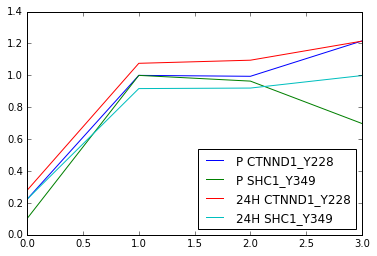

In [4]:
dfSub.plot()

## Plot SHC and CTNND1 clusters

In [5]:
def returnClusterNumber(gene_site, solution_name):
    #for a gene_site and a finsihed solution of solution_name, returns a list (P, 24H) of the cluster objects and 
    # The cluster number gene_site has in that solution.
    ## Gene_site example
    #gene_site = 'CTNND1_Y228'
    #gene_site = 'SHC1_Y349'
    
    cs = []
    if solution_name=='co_occ_linkage':
        cs = [c_link_P, c_link_24H]
    elif solution_name == 'graph_closure':
        cs = [c_g_P, c_g_24H]
    else:
        print("ERROR: Do not recognize the finishing technique")

    #Create the subsets
    ds = [dataObj_P, dataObj_24H]
    name = ['P', '24H']
    indexes = {}
    clusterNum_SOI = {}
    for i in range(0,len(ds)):
        d = ds[i]
        c = cs[i]
        idx = d.df.index.get_loc(gene_site)
        clusterNum = c.labels[solution_name][idx]
        clusterNum_SOI[name[i]] = clusterNum
        indexes[name[i]] = c.get_cluster_members(solution_name, clusterNum)
   
    return cs, clusterNum_SOI 

In [6]:
# Plot the cluster, co-occurrence values of cluster and graph of a cluster
def plotClusterStuff(dataObj, c, coOcc, solution_name, clusterNum, graph_threshold):
        indexes = c.get_cluster_members(solution_name, clusterNum)
        coMat_sub = coOcc.co_matrix.iloc[indexes[0], indexes[0]]
        coSub = c.co_occurrence_matrix('parent')
        coSub.co_matrix = coMat_sub
        label_vec = c.dataObj.df.iloc[indexes].index.values.tolist()
        f_c = coSub.plot(distance_threshold=graph_threshold, label_vec=label_vec)
        
        clusterNum = [np.asscalar(clusterNum)]
        f = dataObj.plot_data('parent', title=solution_name, class_labels=c.labels[solution_name], clusters_to_plot=clusterNum)

        #threshold = 0.5
        coMat_sub[coMat_sub < graph_threshold]=0
        A = coMat_sub.as_matrix()

        G = nx.from_numpy_matrix(A)
        coMat_sub = coMat_sub.rename(columns=lambda x: x.replace('_', '\n'))
        Glabeled = nx.relabel_nodes(G, dict(enumerate(coMat_sub.columns)))

        f_g = plt.figure(3,figsize=(5,5))
        nx.draw(Glabeled,pos=nx.spring_layout(Glabeled), with_labels=True, node_size=2500, font_size=11)
         
        return f_c, f, f_g
            
    

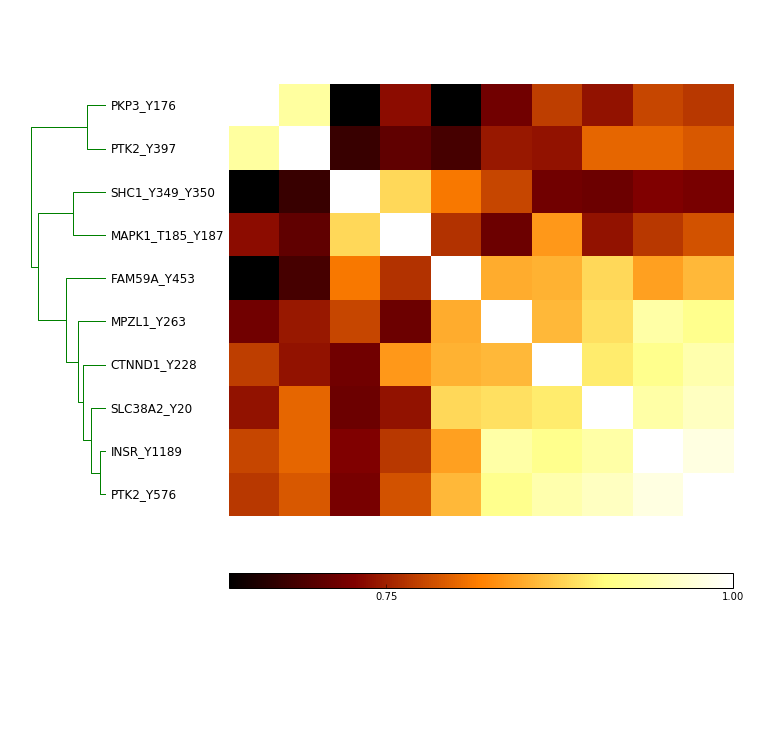

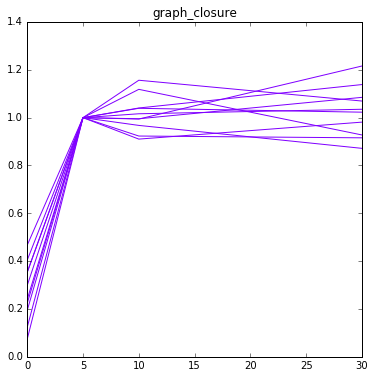

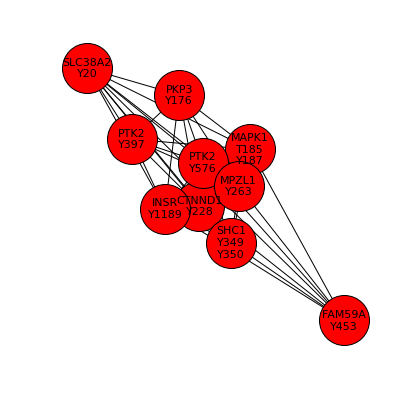

In [7]:
## SHC1_Y349, or CTNND1 graph closure solution in Parental 

#gene_site = 'SHC1_Y349'
gene_site = 'CTNND1_Y228'
solution_name = 'graph_closure'
#solution_name = 'co_occ_linkage'
cs, clusterNum_SOI = returnClusterNumber(gene_site, solution_name)

f_c, f, G_P = plotClusterStuff(dataObj_P, cs[0], coMat_P, solution_name, clusterNum_SOI['P'], graph_threshold)
f_c.set_size_inches(3, 3, forward=True)
f_c.savefig('P_CTNND1_coSub.svg', format='svg', bbox_inches='tight', dpi=1200)
G_P.savefig('P_CTNND1_graph.svg', format='svg', bbox_inches='tight', dpi=1200)

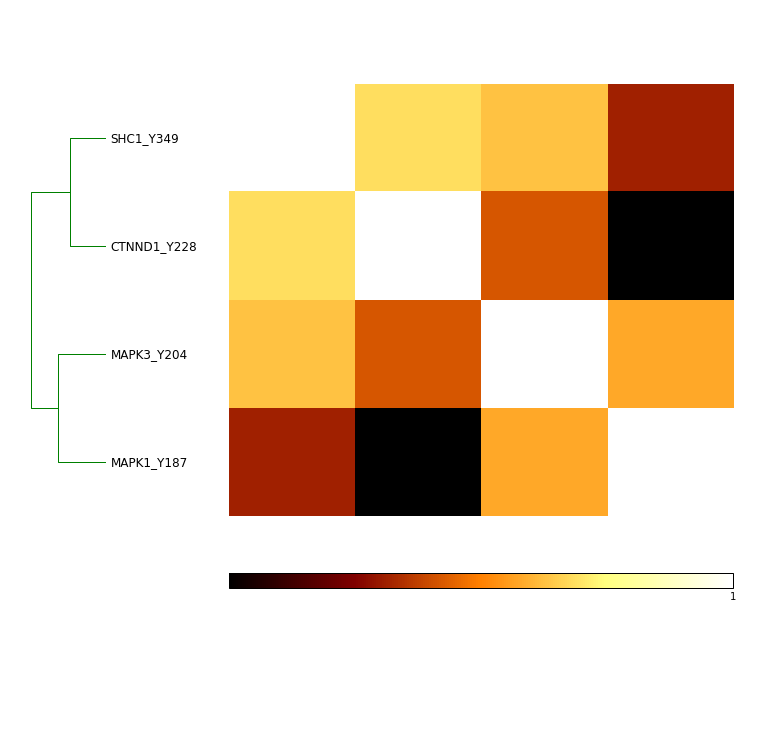

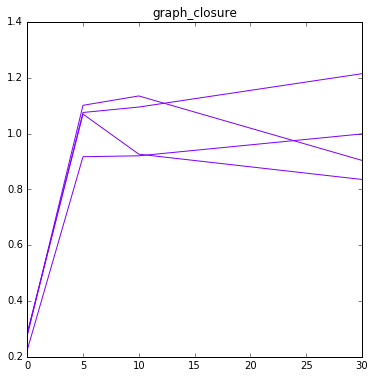

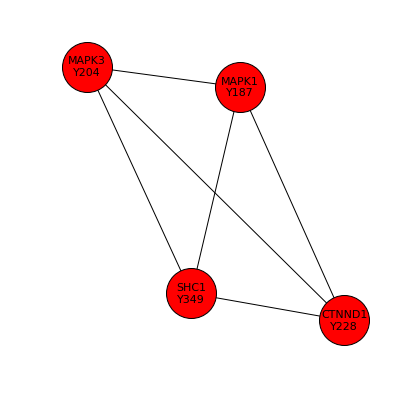

In [8]:
## SHC1/CTNND1 solutions in 24H 

gene_site = 'CTNND1_Y228'
solution_name = 'graph_closure'
#solution_name = 'co_occ_linkage'
cs, clusterNum_SOI = returnClusterNumber(gene_site, solution_name)
f_c, f, G_24H = plotClusterStuff(dataObj_24H, cs[1], coMat_24H, solution_name, clusterNum_SOI['24H'], graph_threshold)
f_c.set_size_inches(3, 3, forward=True)
f_c.savefig('24H_SHCY349_coSub.svg', format='svg', bbox_inches='tight', dpi=1200)
G_24H.savefig('24H_SHC_graph.svg', format='svg', bbox_inches='tight', dpi=1200)